# Once you have your raw data ready to process, you need to group the raw data points based on a unique agent identifier, and then split the points for each agent into tracks.

In [17]:
import trackio as tio
import glob
from IPython.display import Image 

In [18]:
#define raw data files
data_path = './files'
files = glob.glob(f'{data_path}/AIS*.csv')

In [19]:
#create the Dataset
ds = tio.read(raw_files=files,
              data_path='example0')


No dataset.db found in c:\code\trackio\notebooks\example0. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



# Now, split the data contained in the `Dataset` into groups of points. Here, I will use the `MMSI` column as the unique identifier for each agent.

Here:

`groupby` is the data field used to do the grouping

`col_mapper` is a column mapper dictionary

`meta_cols` are data fields in the raw files that you want to maintain as metadata (static data) for each agent

`data_col` are the data fields in the raw files that you want to maintain as dynamic data for each agent's tracks

`prefix` is a prefix added to the name of each grouped agent file

`data_mappers` are data mapper dictionaries that will map raw values as they are being grouped


In [20]:
#split the raw point data by agents
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI',
                                'Name',
                                'AISCode',
                                'Length',
                                'Width'],
                     data_cols=['Time',
                                'X',
                                'Y',
                                'Draft', 
                                'Status',
                                'Coursing',
                                'Speed'],
                     prefix='Vessel_',
                     data_mappers={'Status': tio.mappers.ais['Status'],
                                   'AISCode': tio.mappers.ais['AISCode']},
                     ncores=4)

Grouping points: 100%|██████████| 3/3 [00:00<00:00, 40.54it/s]


# Notice that the metadata for the `Dataset` has updated, and there are now a bunch of grouped point files in the `data_path` location:

In [21]:
ds

Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    3 Processed CSV Files
    498 Unsplit Agent Files
    0 Split Agent Files
Static Data Fields:
    []
Dynamic Data Fields:
    ['X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example0

In [22]:
ds.status

{'Processed': ['./files\\AIS_2021_01_01.csv',
  './files\\AIS_2021_01_01_clipped_to_box.csv',
  './files\\AIS_2021_01_01_clipped_to_polygon.csv'],
 'Unprocessed': [],
 'Split': [],
 'Unsplit': ['c:\\code\\trackio\\notebooks\\example0\\Vessel_367563930_processor13.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_367671080_processor13.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_367797720_processor15.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_367549870_processor14.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_309987000_processor13.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_366998820_processor15.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_367791140_processor15.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_636019179_processor14.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_367546090_processor14.points',
  'c:\\code\\trackio\\notebooks\\example0\\Vessel_367448070_processor14.points'

# At this point, you have grouped the points by agent, but have not split the point groups into individual tracks. 

# You can now refresh the metadata tables to retrieve some information about the agents which might be useful for splitting the tracks.

In [23]:
#refresh the metadata, you must pass agents_only=True if you have not split into tracks yet
ds = ds.refresh_meta(ncores=1, agents_only=True)

Refreshing metadata: 100%|██████████| 498/498 [00:03<00:00, 155.11it/s]

No split track files found, skipping track.db
New meta/databases saved to c:\code\trackio\notebooks\example0


# Notice how no `track.db` file is created, since there are no tracks yet.

# You can now access the `agent.db` metadata table by using the `Dataset.agents` attribute. It's just a geopandas GeoDataFrame. The geometry column contains the bounding box for the agent's data.

In [24]:
ds.agents.head(5)

,MMSI,Name,AISCode,Length,Width,npoints,ntracks,Xmin,Xmax,Ymin,Ymax,Start Time,End Time,File,geometry
Agent ID,,,,,,,,,,,,,,,
Vessel_367563930,367563930,DEAN REINAUER,31.0,35.0,10.0,88,0,-74.1235,-74.02086,40.60178,40.72542,2021-01-01 03:26:26,2021-01-01 15:29:42,c:\code\trackio\notebooks\example0\Vessel_3675...,"POLYGON ((-74.02086 40.60178, -74.02086 40.725..."
Vessel_367671080,367671080,KIRBY MORAN,31.0,28.0,11.0,124,0,-74.12536,-74.04897,40.61606,40.65159,2021-01-01 00:17:29,2021-01-01 15:14:31,c:\code\trackio\notebooks\example0\Vessel_3676...,"POLYGON ((-74.04897 40.61606, -74.04897 40.651..."
Vessel_367797720,367797720,DAISY MAE,NaN,NaN,NaN,1162,0,-74.08706,-74.00295,40.60186,40.673,2021-01-01 01:49:34,2021-01-01 23:58:42,c:\code\trackio\notebooks\example0\Vessel_3677...,"POLYGON ((-74.00295 40.60186, -74.00295 40.673..."
Vessel_367549870,367549870,LT SAMUEL S COURSEN,60.0,52.0,14.0,1244,0,-74.01513,-74.01485,40.69315,40.69343,2021-01-01 00:17:18,2021-01-01 23:59:18,c:\code\trackio\notebooks\example0\Vessel_3675...,"POLYGON ((-74.01485 40.69315, -74.01485 40.693..."
Vessel_309987000,309987000,LILLESAND,80.0,240.0,42.0,501,0,-74.08686,-74.05297,40.62102,40.65222,2021-01-01 00:20:01,2021-01-01 23:58:21,c:\code\trackio\notebooks\example0\Vessel_3099...,"POLYGON ((-74.05297 40.62102, -74.05297 40.652..."


# Now that you have your points grouped, you can split them into tracks. The simplest way to do this is by applying a spatiotemporal threshold.

# This works by looking at consecutive points belonging to an agent. If the gap between two consecutive points is further in distance or time than the user-defined thresholds, then this corresponds to a breakpoint for a new track.

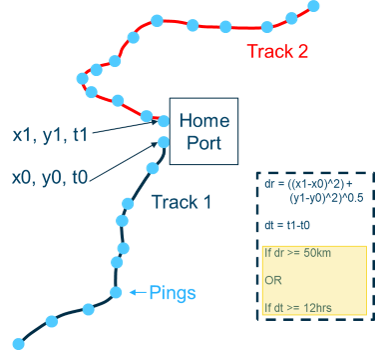

In [25]:
Image(filename='../trackio/supporting/readme_pointsplitting.png')

# Here, adding `remove=True` simply deletes the point files after they are split into track files to avoid data duplication (if desired). It may be advantageous to pass `remove=False` if you want to experiment with different splitting thresholds.

In [26]:
#split using spatiotemporal thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*24, #time in seconds
                                    distance=0.7, #distance in CRS units (degrees here)
                                    ncores=4,
                                    remove=True)

Splitting tracks using spatiotemporal threshold: 100%|██████████| 172/172 [00:02<00:00, 73.18it/s]


# Once you refresh the metdata, you can view the `tracks.db` table using the `Dataset.tracks` attribute.

In [27]:
#refresh the metadata
ds = ds.refresh_meta(ncores=4)

#show the track metadata table
ds.tracks.head(5)

Refreshing metadata:   0%|          | 0/172 [00:00<?, ?it/s]

Refreshing metadata: 100%|██████████| 172/172 [00:02<00:00, 77.22it/s]


New meta/databases saved to c:\code\trackio\notebooks\example0


,MMSI,Name,AISCode,Length,Width,Agent ID,npoints,Xmin,Xmax,Ymin,...,Yend,Effective Distance,Min Temporal Resolution,Mean Temporal Resolution,Max Temporal Resolution,Min Spatial Resolution,Mean Spatial Resolution,Max Spatial Resolution,Sinuosity,geometry
Track ID,,,,,,,,,,,,,,,,,,,,,
Vessel_367459570_T0,367459570,CORAL COAST,31.0,34.0,9.0,Vessel_367459570,59,-74.02483,-73.95450,40.69800,...,40.76033,0.055000,50,68.448276,72,0.001897,0.002979,0.003862,3.141060,"POLYGON ((-73.95450 40.69800, -73.95450 40.760..."
Vessel_367770270_T0,367770270,CAPT BRIAN A MCALLIS,31.0,NaN,NaN,Vessel_367770270,359,-74.12577,-74.05318,40.61980,...,40.64352,0.020812,9,180.701117,40923,0.000000,0.000705,0.004033,12.121131,"POLYGON ((-74.05318 40.61980, -74.05318 40.651..."
Vessel_367586480_T0,367586480,MANHATTAN ELITE,60.0,25.0,6.0,Vessel_367586480,1244,-74.01035,-74.01013,40.74731,...,40.74741,0.000072,9,68.671762,82,0.000000,0.000030,0.000125,519.095409,"POLYGON ((-74.01013 40.74731, -74.01013 40.747..."
Vessel_367790830_T0,367790830,OWLS HEAD,60.0,NaN,NaN,Vessel_367790830,523,-74.00614,-73.94803,40.70187,...,40.75805,0.060905,6,161.599617,44332,0.000000,0.002436,0.009810,20.876767,"POLYGON ((-73.94803 40.70187, -73.94803 40.761..."
Vessel_367796040_T0,367796040,SEA FOX,31.0,22.0,7.0,Vessel_367796040,1134,-74.07762,-73.95417,40.66082,...,40.68622,0.000030,10,75.339806,7989,0.000000,0.000360,0.004348,13606.709065,"POLYGON ((-73.95417 40.66082, -73.95417 40.760..."


# Now you can look at some high level information about the dataset before going further.

In [28]:
ds

Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    172 Split Agent Files
Static Data Fields:
    ['AISCode', 'Agent ID', 'Length', 'MMSI', 'Name', 'Width']
Dynamic Data Fields:
    ['Coursing', 'Draft', 'Speed', 'Status', 'Time', 'X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example0

In [29]:
#how many agents, how many points, how many tracks
len(ds.agents), ds.agents.npoints.sum(), ds.agents.ntracks.sum()

(172, 82334, 172)

In [30]:
#how many tracks, how many points, start end times
len(ds.tracks), ds.tracks.npoints.sum(), ds.tracks['Start Time'].min(), ds.tracks['End Time'].max()

(172,
 82334,
 Timestamp('2021-01-01 00:17:12'),
 Timestamp('2021-01-01 23:59:59'))

In [31]:
#stats of various metadata fields
ds.tracks['Track Length'].describe()

count    172.000000
mean       0.298803
std        0.449133
min        0.000000
25%        0.037387
50%        0.181602
75%        0.357185
max        3.633101
Name: Track Length, dtype: float64

In [32]:
#stats of various metadata fields
ds.agents['AISCode'].value_counts()

AISCode
31.0    82
60.0    28
90.0    18
80.0     6
70.0     4
37.0     4
36.0     2
59.0     1
Name: count, dtype: int64